# Behavioral analysis of openfMRI dataset ds102 (Flanker task)

See also https://openfmri.org/dataset/ds000102/

## Import libraries

In [1]:
import pandas

In [2]:
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
import numpy as np
%matplotlib inline

## Write a regular expression that extracts important info from filename

In [3]:
reg = re.compile('.*/sub-(?P<subj_idx>[0-9]+)/func/sub-[0-9]+_task-flankertask_run-(?P<run>[0-9]+)_events.tsv')

Get files

In [4]:
fns = glob.glob(os.path.join(os.environ['HOME'], 'data/openfmri/ds102/sub*/func/sub-*_task-flankertask_run-*_events.tsv'))

Loop over files and make a dataframe, using the regular expression to insert subject info

In [5]:
dfs = []

for fn in fns:
    d = reg.match(fn).groupdict()
    
    dfs.append(pandas.read_csv(fn, sep='\t', index_col=False,na_values=['n/a', 'junk']))
    dfs[-1]['subj_idx'] = d['subj_idx']
    dfs[-1]['run'] = d['run']
    
df = pandas.concat(dfs)

In [6]:
df['correct'] = df.Rsponse.map({0:'error', 1:'correct'})

In [7]:
sns.set_style('white')

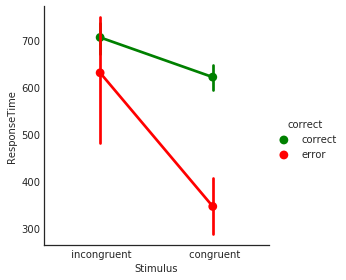

In [8]:
sns.factorplot('Stimulus', 'ResponseTime', 'correct', df, ci=67, units='subj_idx', hue_order=['correct', 'error'], palette=['green', 'red'])

Use groupby to get subject-wise summary of behavioral data

In [9]:
df.groupby(['subj_idx', 'Stimulus', 'Rsponse']).mean().ResponseTime

subj_idx  Stimulus      Rsponse
01         congruent    0           392.000000
                        1           507.434783
           incongruent  1           550.708333
02         congruent    1           610.583333
           incongruent  1           694.333333
03         congruent    0           490.000000
                        1           638.521739
           incongruent  1           766.166667
04         congruent    1           773.958333
           incongruent  1           863.583333
05         congruent    1           554.541667
           incongruent  1           658.166667
06         congruent    1           853.750000
           incongruent  1           857.375000
07         congruent    0           481.000000
                        1           423.391304
           incongruent  0           356.000000
                        1           489.434783
08         congruent    0             0.000000
                        1           548.304348
           incongruent  0   

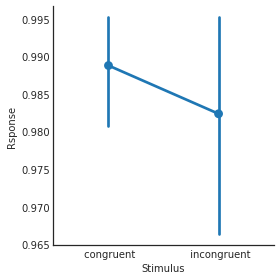

In [10]:
correct = df.groupby(['subj_idx', 'Stimulus']).mean().Rsponse

sns.factorplot('Stimulus', 'Rsponse', data=correct.reset_index(), )

## Use FacetGrid to make very informative plots with very little codfe

I think this looks a bit prettier than standard settings

In [11]:

sns.set_context('poster')
sns.set_style('white')

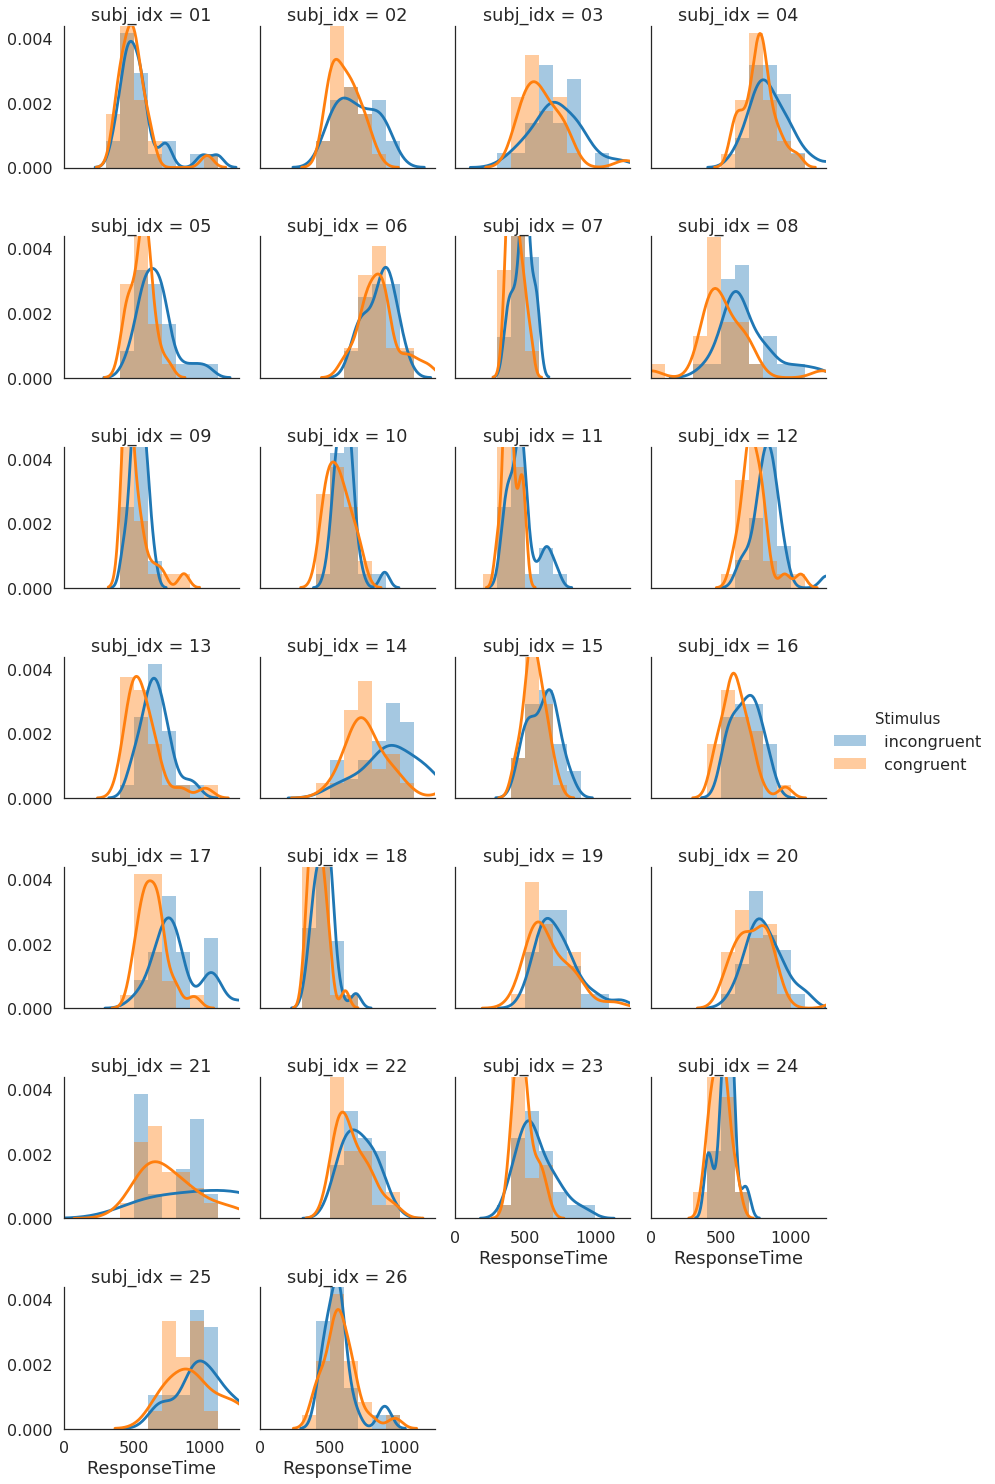

In [12]:
fac = sns.FacetGrid(df, col='subj_idx', col_wrap=4, hue='Stimulus')

fac.map(sns.distplot, 'ResponseTime', bins=np.arange(0, 1200, 100)).add_legend().set(xlim=(0, 1250))

## Fit Hierachidal DDM

In [13]:
import hddm

/home/ubuntu/miniconda2/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [14]:
# RTs need to be in seconds (VERY important for informative priors!)

df['rt'] = df['ResponseTime'] / 1000.
df['response'] = df['Rsponse']

# Remove outliers (t0 can never be shorter than fastest trial)
df = df[df.rt > .3]

In [15]:
# Fit DDM, where drift rates varies depending on congruent versus incongruent sitmulus
model = hddm.HDDM(df, depends_on={'v':'Stimulus'})

In [16]:
# Use MAP fitting to get a reasonable starting point, otherwise (slice) MCMC sampler fails
model.find_starting_values()

/home/ubuntu/miniconda2/lib/python2.7/site-packages/scipy/optimize/optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/ubuntu/miniconda2/lib/python2.7/site-packages/scipy/optimize/optimize.py:1851: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


We sample using MCMC. The number of samples is very low for speed considerations. If you want good estimates of the tails of the posteriors, definetly use more.

In [17]:
model.sample(1000, burn=50, thin=10)

/home/ubuntu/miniconda2/lib/python2.7/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 1000 of 1000 complete in 37.5 sec

Plotting a
Plotting a_std
Plotting v( congruent)
Plotting v( incongruent)
Plotting v_std
Plotting t
Plotting t_std


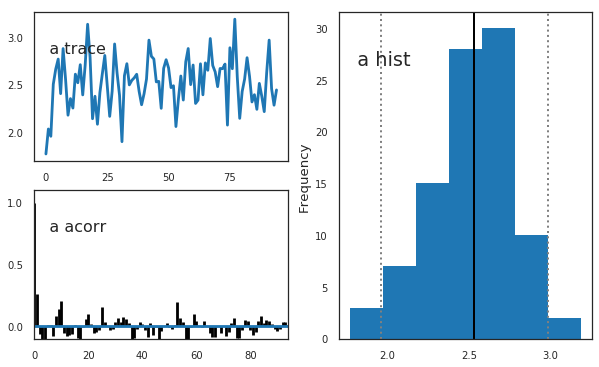

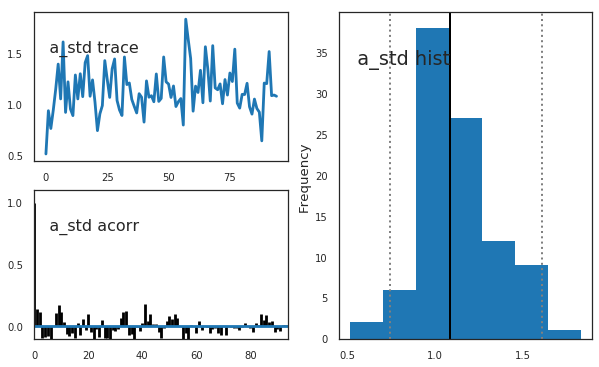

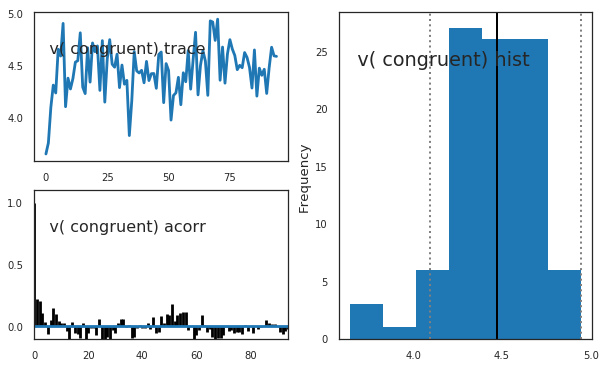

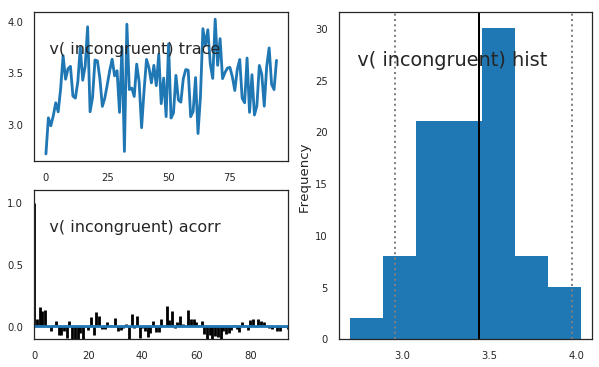

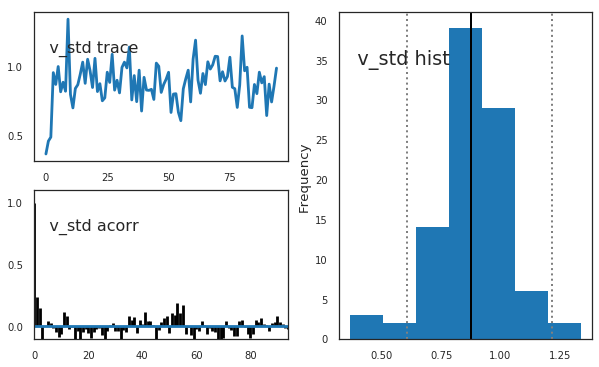

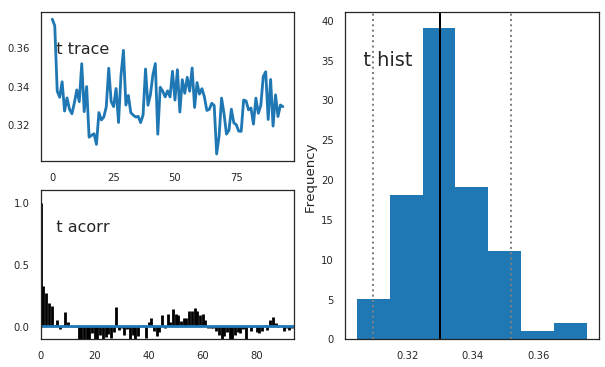

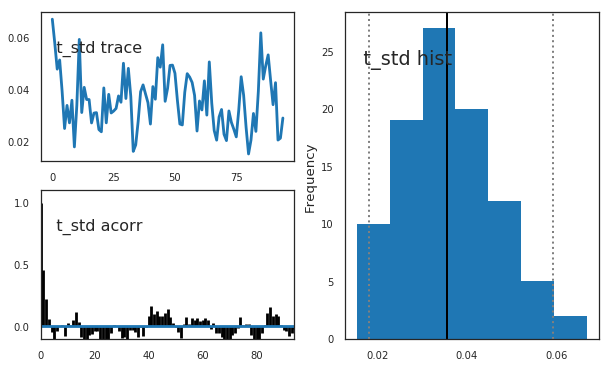

In [18]:
model.plot_posteriors()

In [19]:
sns.reset_orig()

In [20]:
df.subj_idx.unique().shape

(26,)

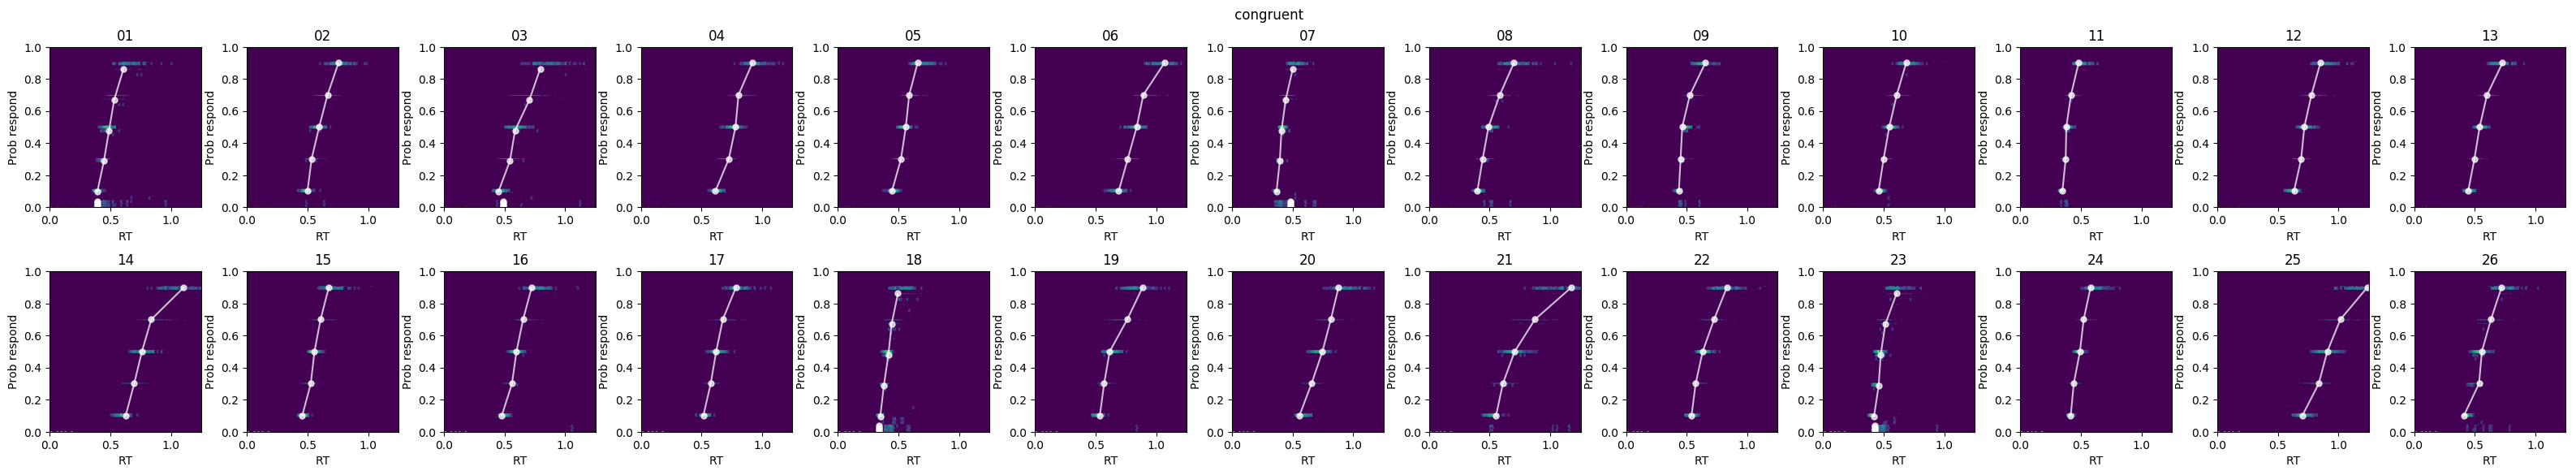

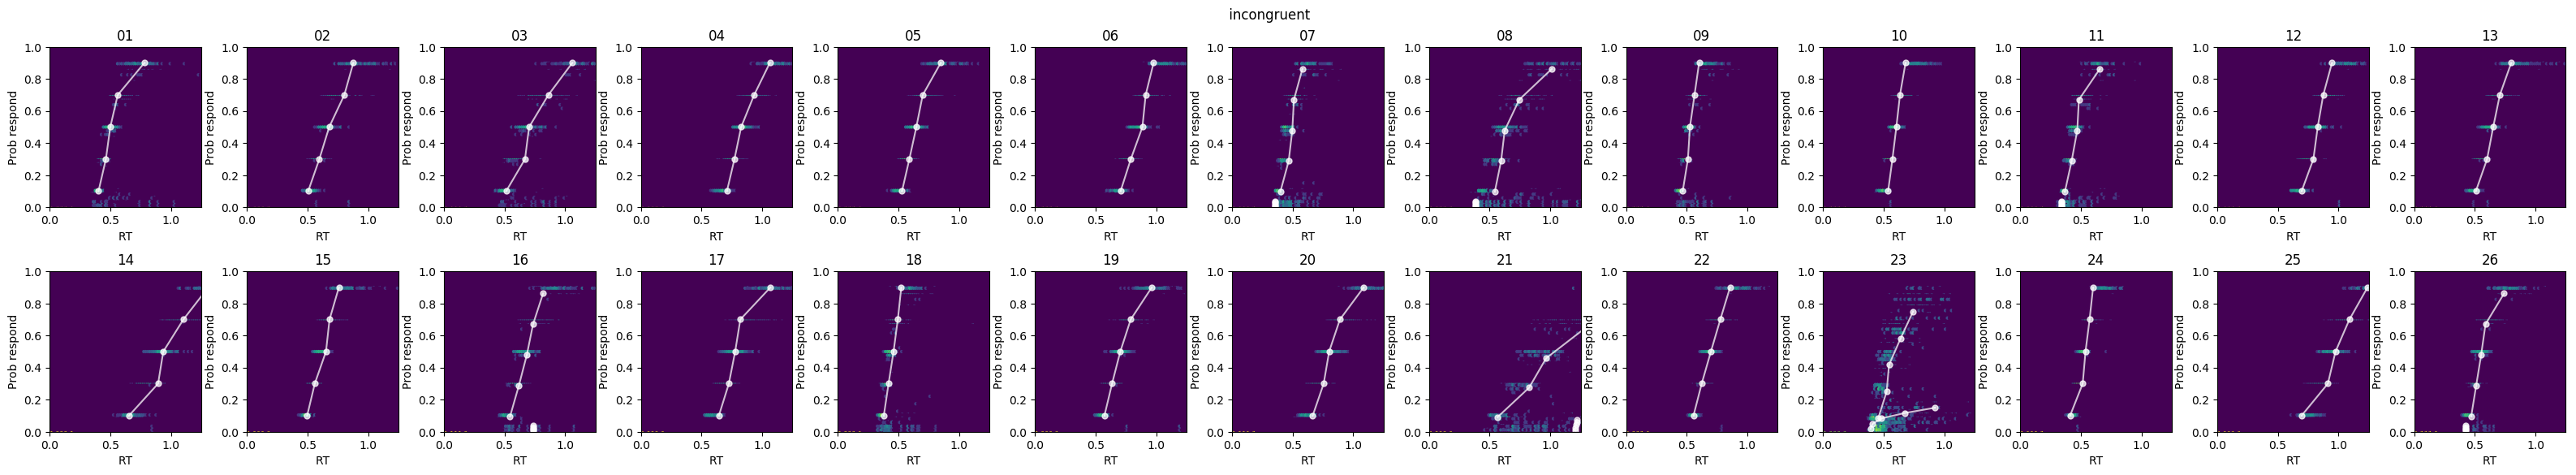

In [21]:
model.plot_posterior_quantiles(columns=13, figsize=(40, 6), value_range=(0, 1.25), samples=100, hexbin=True, data_plot_kwargs={'markersize':5, 'marker':'o', 'markerfacecolor':'white', 'color':'white', 'alpha':0.75})

In [22]:
subj_nodes = model.get_subj_nodes()
subj_nodes = subj_nodes[subj_nodes.knode_name == 'v_subj']
tmp = subj_nodes[['subj_idx', 'map', 'tag', 'node']]
tmp['tag'] = tmp['tag'].map(lambda x: x[0][1:])

/home/ubuntu/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [23]:
tmp

,subj_idx,map,tag,node
v_subj( congruent).01,01,2.050685,congruent,v_subj( congruent).01
v_subj( congruent).02,02,2.068387,congruent,v_subj( congruent).02
v_subj( congruent).03,03,2.026980,congruent,v_subj( congruent).03
v_subj( congruent).04,04,2.059632,congruent,v_subj( congruent).04
v_subj( congruent).05,05,2.075866,congruent,v_subj( congruent).05
v_subj( congruent).06,06,2.038962,congruent,v_subj( congruent).06
v_subj( congruent).07,07,2.072724,congruent,v_subj( congruent).07
v_subj( congruent).08,08,2.057918,congruent,v_subj( congruent).08
v_subj( congruent).09,09,2.078072,congruent,v_subj( congruent).09
v_subj( congruent).10,10,2.075397,congruent,v_subj( congruent).10


In [24]:
tmp['E'] = tmp['node'].apply(lambda node: node.trace[:].mean())

/home/ubuntu/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [25]:
s = tmp.pivot_table(index='subj_idx', columns='tag', values='E')
s

tag,congruent,incongruent
subj_idx,,
01,3.684125,3.078756
02,4.757867,3.606698
03,3.262331,2.417312
04,4.824076,3.984612
05,5.249198,3.738392
06,4.657317,4.453586
07,4.697876,3.166603
08,3.786905,2.260221
09,4.971235,4.142584


In [26]:
s.to_csv('drift_rates.csv')

In [27]:
hddm.__version__

'0.6.0'